In [25]:
# ===================================================================
# STEP 1: CHECK GPU AND INSTALL DEPENDENCIES
# ===================================================================

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: GPU not available! Enable GPU in Runtime > Change runtime type")
print("="*60)

# Install required packages
!pip install ultralytics -q
!pip install kaggle -q

from ultralytics import YOLO
import os
from IPython.display import Image, display
import yaml
from google.colab import files

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [5]:
# ===================================================================
# STEP 2: SETUP KAGGLE API
# ===================================================================

print("\n=== KAGGLE API SETUP ===")
print("\nHow to get your kaggle.json:")
print("1. Go to https://www.kaggle.com")
print("2. Click on your profile picture (top right)")
print("3. Go to 'Settings'")
print("4. Scroll to 'API' section")
print("5. Click 'Create New Token'")
print("6. Download kaggle.json file")
print("\n" + "="*60)

# Upload kaggle.json
print("\nPlease upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify kaggle.json content
import json
try:
    with open('/root/.kaggle/kaggle.json', 'r') as f:
        kaggle_config = json.load(f)
        if 'username' in kaggle_config and 'key' in kaggle_config:
            print(f"✓ Kaggle API configured successfully!")
            print(f"✓ Username: {kaggle_config['username']}")
        else:
            print("❌ ERROR: kaggle.json is missing 'username' or 'key'")
            print("Please download a fresh kaggle.json from Kaggle settings")
            raise ValueError("Invalid kaggle.json format")
except FileNotFoundError:
    print("❌ ERROR: kaggle.json not found")
    print("Please make sure you uploaded the file")
    raise


=== KAGGLE API SETUP ===

How to get your kaggle.json:
1. Go to https://www.kaggle.com
2. Click on your profile picture (top right)
3. Go to 'Settings'
4. Scroll to 'API' section
5. Click 'Create New Token'
6. Download kaggle.json file


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✓ Kaggle API configured successfully!
✓ Username: sujith1546


In [6]:
# ===================================================================
# STEP 3: DOWNLOAD DATASET FROM KAGGLE
# ===================================================================

print("\n=== DOWNLOADING DATASET FROM KAGGLE ===")
print("Dataset: YOLO Drone Detection Dataset by muki2003")
print("Downloading... This may take 3-5 minutes")
print("="*60 + "\n")

# Test Kaggle API first
print("Testing Kaggle API connection...")
try:
    !kaggle datasets list --page-size 1
    print("✓ Kaggle API working!")
except Exception as e:
    print(f"❌ Kaggle API test failed: {e}")
    print("\nPlease:")
    print("1. Delete the uploaded kaggle.json")
    print("2. Go to Kaggle.com → Settings → API")
    print("3. Click 'Expire API Token' (if exists)")
    print("4. Click 'Create New API Token'")
    print("5. Download the NEW kaggle.json")
    print("6. Re-run this cell and upload the NEW file")
    raise

# Download the dataset
print("\nDownloading dataset...")
download_result = !kaggle datasets download -d muki2003/yolo-drone-detection-dataset

# Check if download was successful
if os.path.exists('yolo-drone-detection-dataset.zip'):
    print("✓ Dataset downloaded successfully!")

    # Unzip the dataset
    print("\nExtracting dataset...")
    !unzip -q yolo-drone-detection-dataset.zip -d /content/drone_dataset

    # Clean up zip file
    !rm yolo-drone-detection-dataset.zip

    print("✓ Dataset extracted to /content/drone_dataset")
else:
    print("❌ ERROR: Dataset download failed!")
    print("\nTroubleshooting steps:")
    print("1. Check your internet connection")
    print("2. Verify your Kaggle account is verified (phone verification)")
    print("3. Make sure you accepted the dataset rules on Kaggle website")
    print("4. Try downloading manually from: https://www.kaggle.com/datasets/muki2003/yolo-drone-detection-dataset")

    # Show download output for debugging
    print("\nDownload output:")
    for line in download_result:
        print(line)

    raise FileNotFoundError("Dataset download failed")



=== DOWNLOADING DATASET FROM KAGGLE ===
Dataset: YOLO Drone Detection Dataset by muki2003
Downloading... This may take 3-5 minutes

Testing Kaggle API connection...
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: --page-size 1
✓ Kaggle API working!

✓ Dataset downloaded successfully!

Extracting dataset...
✓ Dataset extracted to /content/drone_dataset


In [8]:
# ===================================================================
# STEP 4: VERIFY DATASET STRUCTURE & FIX NESTED FOLDERS
# ===================================================================

print("\n=== VERIFYING DATASET STRUCTURE ===")

# Check for nested structure (common with Kaggle datasets)
dataset_root = '/content/drone_dataset'

print("\nChecking for nested folders...")
if os.path.exists(os.path.join(dataset_root, 'drone_dataset')):
    print("✓ Detected nested 'drone_dataset' folder")
    print("Fixing structure...")

    import shutil
    nested_path = os.path.join(dataset_root, 'drone_dataset')

    # Move all contents up one level
    for item in os.listdir(nested_path):
        src = os.path.join(nested_path, item)
        dst = os.path.join(dataset_root, item)

        # Remove destination if exists
        if os.path.exists(dst):
            if os.path.isdir(dst):
                shutil.rmtree(dst)
            else:
                os.remove(dst)

        # Move item
        shutil.move(src, dst)

    # Remove empty nested folder
    os.rmdir(nested_path)
    print("✓ Structure fixed!")
else:
    print("✓ No nested structure detected")

# Set dataset path
dataset_path = dataset_root

# Show current structure
print("\n=== CURRENT STRUCTURE ===")
print(f"Dataset location: {dataset_path}")
!ls -la {dataset_path}/

# Define all possible paths
train_images = os.path.join(dataset_path, 'train/images')
train_labels = os.path.join(dataset_path, 'train/labels')
valid_images = os.path.join(dataset_path, 'valid/images')
valid_labels = os.path.join(dataset_path, 'valid/labels')

# Check for test folder (might be 'test' or missing)
test_exists = False
if os.path.exists(os.path.join(dataset_path, 'test/images')):
    test_images = os.path.join(dataset_path, 'test/images')
    test_labels = os.path.join(dataset_path, 'test/labels')
    test_exists = True
    print("✓ Found 'test' folder")
else:
    print("⚠️ No 'test' folder found, will use 'valid' for testing")
    test_images = valid_images
    test_labels = valid_labels

# Count files
print("\n=== FILE COUNTS ===")
def count_files(path, name):
    if os.path.exists(path):
        files = [f for f in os.listdir(path) if not f.startswith('.') and f.endswith(('.jpg', '.png', '.jpeg', '.txt'))]
        count = len(files)
        print(f"✓ {name}: {count} files")
        return count
    else:
        print(f"✗ {name}: NOT FOUND - {path}")
        return 0

train_img_count = count_files(train_images, "Train Images")
train_lbl_count = count_files(train_labels, "Train Labels")
valid_img_count = count_files(valid_images, "Valid Images")
valid_lbl_count = count_files(valid_labels, "Valid Labels")

if test_exists:
    test_img_count = count_files(test_images, "Test Images")
    test_lbl_count = count_files(test_labels, "Test Labels")

# Verify mapping (check if image and label names match)
print("\n=== VERIFYING IMAGE-LABEL MAPPING ===")
def verify_mapping(img_dir, lbl_dir, split_name):
    if not os.path.exists(img_dir) or not os.path.exists(lbl_dir):
        print(f"✗ {split_name}: Folders not found")
        return False

    img_names = set([os.path.splitext(f)[0] for f in os.listdir(img_dir)
                     if f.endswith(('.jpg', '.png', '.jpeg'))])
    lbl_names = set([os.path.splitext(f)[0] for f in os.listdir(lbl_dir)
                     if f.endswith('.txt')])

    matched = len(img_names & lbl_names)
    total = len(img_names)

    if matched == total and total > 0:
        print(f"✓ {split_name}: {matched}/{total} perfectly matched")
        return True
    elif total == 0:
        print(f"✗ {split_name}: No images found!")
        return False
    else:
        unmatched_imgs = img_names - lbl_names
        unmatched_lbls = lbl_names - img_names
        print(f"⚠️ {split_name}: {matched}/{total} matched")
        if unmatched_imgs:
            print(f"   - {len(unmatched_imgs)} images without labels")
        if unmatched_lbls:
            print(f"   - {len(unmatched_lbls)} labels without images")
        return matched > 0

train_ok = verify_mapping(train_images, train_labels, "Train")
valid_ok = verify_mapping(valid_images, valid_labels, "Valid")

if test_exists:
    test_ok = verify_mapping(test_images, test_labels, "Test")

# Check if we can proceed
if not train_ok or not valid_ok:
    print("\n❌ ERROR: Dataset structure issues detected!")
    print("\nExpected structure:")
    print("  drone_dataset/")
    print("    ├── train/")
    print("    │   ├── images/  (jpg/png files)")
    print("    │   └── labels/  (txt files)")
    print("    └── valid/")
    print("        ├── images/")
    print("        └── labels/")
    raise ValueError("Invalid dataset structure")
else:
    print("\n✓ Dataset structure verified successfully!")


=== VERIFYING DATASET STRUCTURE ===

Checking for nested folders...
✓ Detected nested 'drone_dataset' folder
Fixing structure...
✓ Structure fixed!

=== CURRENT STRUCTURE ===
Dataset location: /content/drone_dataset
total 20
drwxr-xr-x 4 root root 4096 Oct 22 04:40 .
drwxr-xr-x 1 root root 4096 Oct 22 04:36 ..
-rw-r--r-- 1 root root   97 Jul 24  2022 data.yaml
drwxr-xr-x 4 root root 4096 Oct 22 04:36 train
drwxr-xr-x 4 root root 4096 Oct 22 04:36 valid
⚠️ No 'test' folder found, will use 'valid' for testing

=== FILE COUNTS ===
✓ Train Images: 1012 files
✓ Train Labels: 1012 files
✓ Valid Images: 347 files
✓ Valid Labels: 348 files

=== VERIFYING IMAGE-LABEL MAPPING ===
✓ Train: 1012/1012 perfectly matched
✓ Valid: 347/347 perfectly matched

✓ Dataset structure verified successfully!


In [9]:
# ===================================================================
# STEP 5: CREATE YAML CONFIGURATION
# ===================================================================

print("\n=== CREATING YAML CONFIGURATION ===")

# Create data.yaml file for YOLO training
data_yaml = {
    'path': dataset_path,
    'train': 'train/images',
    'val': 'valid/images',
    'names': {
        0: 'drone'
    },
    'nc': 1
}

# Add test path if it exists
if test_exists:
    data_yaml['test'] = 'test/images'

# Save YAML file
yaml_path = os.path.join(dataset_path, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"✓ Configuration saved: {yaml_path}")
print("\nYAML Contents:")
print("-" * 40)
with open(yaml_path, 'r') as f:
    print(f.read())
print("-" * 40)

print("\n✓ Ready for training!")



=== CREATING YAML CONFIGURATION ===
✓ Configuration saved: /content/drone_dataset/data.yaml

YAML Contents:
----------------------------------------
names:
  0: drone
nc: 1
path: /content/drone_dataset
train: train/images
val: valid/images

----------------------------------------

✓ Ready for training!



=== VISUALIZING SAMPLE TRAINING IMAGES ===


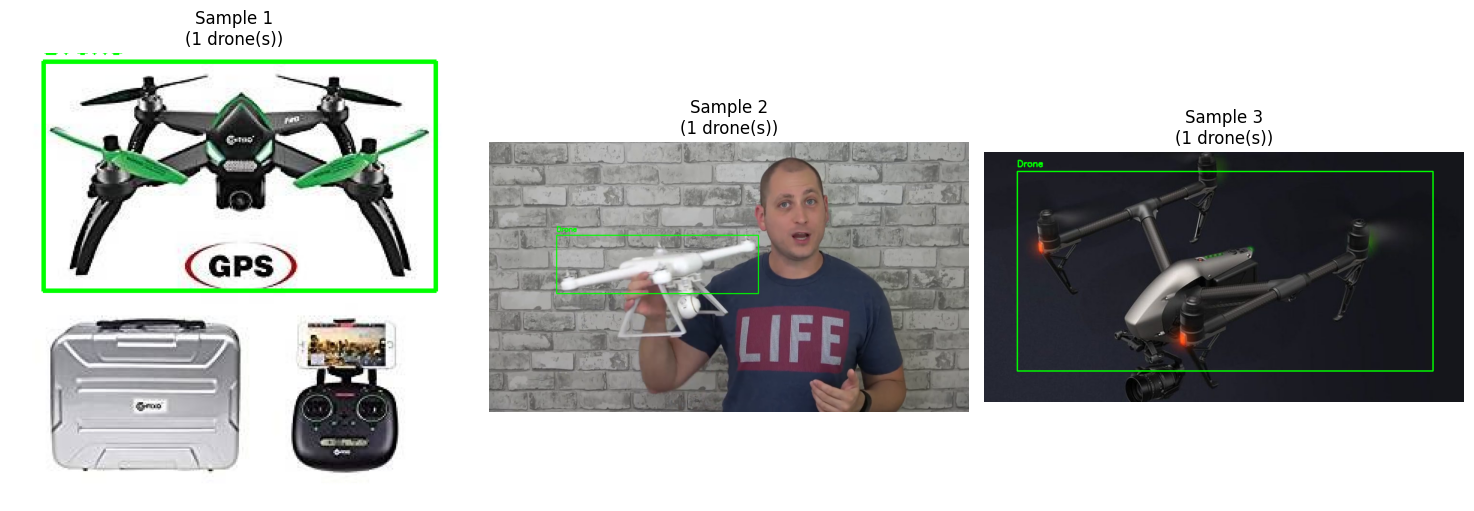

In [26]:
# ===================================================================
# STEP 6: VISUALIZE SAMPLE IMAGES
# ===================================================================

print("\n=== VISUALIZING SAMPLE TRAINING IMAGES ===")

import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(img_dir, lbl_dir, num_samples=3):
    """Display images with bounding boxes"""

    img_files = [f for f in os.listdir(img_dir)
                 if f.endswith(('.jpg', '.png', '.jpeg'))][:num_samples]

    fig, axes = plt.subplots(1, len(img_files), figsize=(15, 5))
    if len(img_files) == 1:
        axes = [axes]

    for idx, img_file in enumerate(img_files):
        # Read image
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read labels
        lbl_file = os.path.splitext(img_file)[0] + '.txt'
        lbl_path = os.path.join(lbl_dir, lbl_file)

        bbox_count = 0
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id, x_center, y_center, width, height = map(float, parts[:5])

                        # Convert to pixel coordinates
                        x_center *= w
                        y_center *= h
                        width *= w
                        height *= h

                        x1 = int(x_center - width/2)
                        y1 = int(y_center - height/2)
                        x2 = int(x_center + width/2)
                        y2 = int(y_center + height/2)

                        # Draw bounding box
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, 'Drone', (x1, max(y1-10, 0)),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                        bbox_count += 1

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Sample {idx+1}\n({bbox_count} drone(s))')

    plt.tight_layout()
    plt.show()

visualize_samples(train_images, train_labels, num_samples=3)

In [27]:
# ===================================================================
# STEP 7: TRAIN THE MODEL
# ===================================================================

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

# Load pre-trained YOLO model
print("\nLoading YOLOv11n (nano) model...")
model = YOLO('yolo11n.pt')

print("\n📋 Training Configuration:")
print("  - Model: YOLOv11 Nano")
print("  - Epochs: 50")
print("  - Image Size: 640x640")
print("  - Batch Size: 16")
print("  - Device: GPU (CUDA)")
print("\n⏱️ Estimated Time: 30-60 minutes")
print("="*60 + "\n")

# Train the model
results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name='drone_detection',
    patience=10,
    save=True,
    plots=True,
    device=0,
    workers=2,
    project='runs/detect',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    close_mosaic=10,
    cache=False,
    amp=True,
    verbose=True
)

print("\n" + "="*60)
print("✓ TRAINING COMPLETED!")
print("="*60)


STARTING TRAINING

Loading YOLOv11n (nano) model...

📋 Training Configuration:
  - Model: YOLOv11 Nano
  - Epochs: 50
  - Image Size: 640x640
  - Batch Size: 16
  - Device: GPU (CUDA)

⏱️ Estimated Time: 30-60 minutes

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drone_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, 

In [28]:
# ===================================================================
# STEP 8: EVALUATE MODEL
# ===================================================================

print("\n=== MODEL EVALUATION ===")

# Load best model
best_model_path = 'runs/detect/drone_detection/weights/best.pt'
model = YOLO(best_model_path)

# Validate
metrics = model.val()

print("\n" + "="*60)
print("📊 VALIDATION METRICS")
print("="*60)
print(f"mAP@50:        {metrics.box.map50:.4f}  (Target: >0.85)")
print(f"mAP@50-95:     {metrics.box.map:.4f}   (Target: >0.60)")
print(f"Precision:     {metrics.box.mp:.4f}   (Target: >0.80)")
print(f"Recall:        {metrics.box.mr:.4f}   (Target: >0.80)")
print(f"F1-Score:      {2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr):.4f}")
print("="*60)

# Performance interpretation
if metrics.box.map50 > 0.85:
    print("✓ EXCELLENT performance!")
elif metrics.box.map50 > 0.70:
    print("✓ GOOD performance!")
else:
    print("⚠️ Consider training for more epochs or using larger model")



=== MODEL EVALUATION ===
Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2422.4±1644.5 MB/s, size: 170.5 KB)
val: Scanning /content/drone_dataset/valid/labels.cache... 347 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 347/347 738.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 3.0it/s 7.3s
                   all        347        369      0.877      0.767      0.838      0.492
Speed: 1.6ms preprocess, 3.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/runs/detect/val

📊 VALIDATION METRICS
mAP@50:        0.8377  (Target: >0.85)
mAP@50-95:     0.4920   (Target: >0.60)
Precision:     0.8767   (Target: >0.80)
Recall:        0.7669   (Target: >0.80)
F1-Score:      0.8182
✓ GOOD performance!



=== RUNNING TEST PREDICTIONS ===

image 1/1 /content/drone_dataset/valid/images/0241.jpg: 320x640 1 drone, 19.0ms
Speed: 2.4ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Results saved to /content/runs/detect/predictions

image 1/1 /content/drone_dataset/valid/images/0088.jpg: 640x512 1 drone, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)
Results saved to /content/runs/detect/predictions

image 1/1 /content/drone_dataset/valid/images/0049.jpg: 384x640 1 drone, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predictions

image 1/1 /content/drone_dataset/valid/images/foto02756.jpg: 384x640 1 drone, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predictions

image 1/1 /content/drone_dataset/valid/images/fo

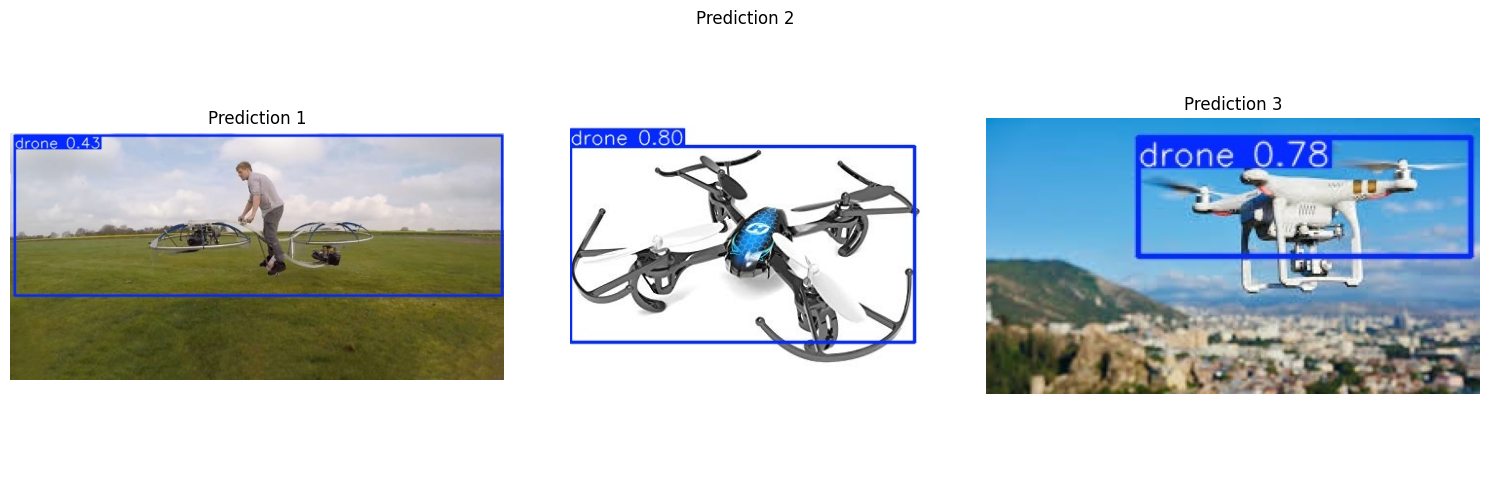

In [29]:
# ===================================================================
# STEP 9: TEST PREDICTIONS
# ===================================================================

print("\n=== RUNNING TEST PREDICTIONS ===")

# Predict on test images
test_files = [f for f in os.listdir(test_images) if f.endswith(('.jpg', '.png'))][:5]

for img_file in test_files:
    img_path = os.path.join(test_images, img_file)
    results = model.predict(
        source=img_path,
        conf=0.25,
        iou=0.45,
        save=True,
        project='runs/detect',
        name='predictions',
        exist_ok=True
    )

print(f"✓ Predictions saved to: runs/detect/predictions/")

# Display predictions
from PIL import Image as PILImage

pred_dir = 'runs/detect/predictions'
if os.path.exists(pred_dir):
    pred_files = [f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))][:3]

    if pred_files:
        fig, axes = plt.subplots(1, len(pred_files), figsize=(15, 5))
        if len(pred_files) == 1:
            axes = [axes]

        for idx, img_file in enumerate(pred_files):
            img = PILImage.open(os.path.join(pred_dir, img_file))
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f'Prediction {idx+1}')

        plt.tight_layout()
        plt.show()


=== TRAINING VISUALIZATIONS ===

📊 Confusion Matrix:


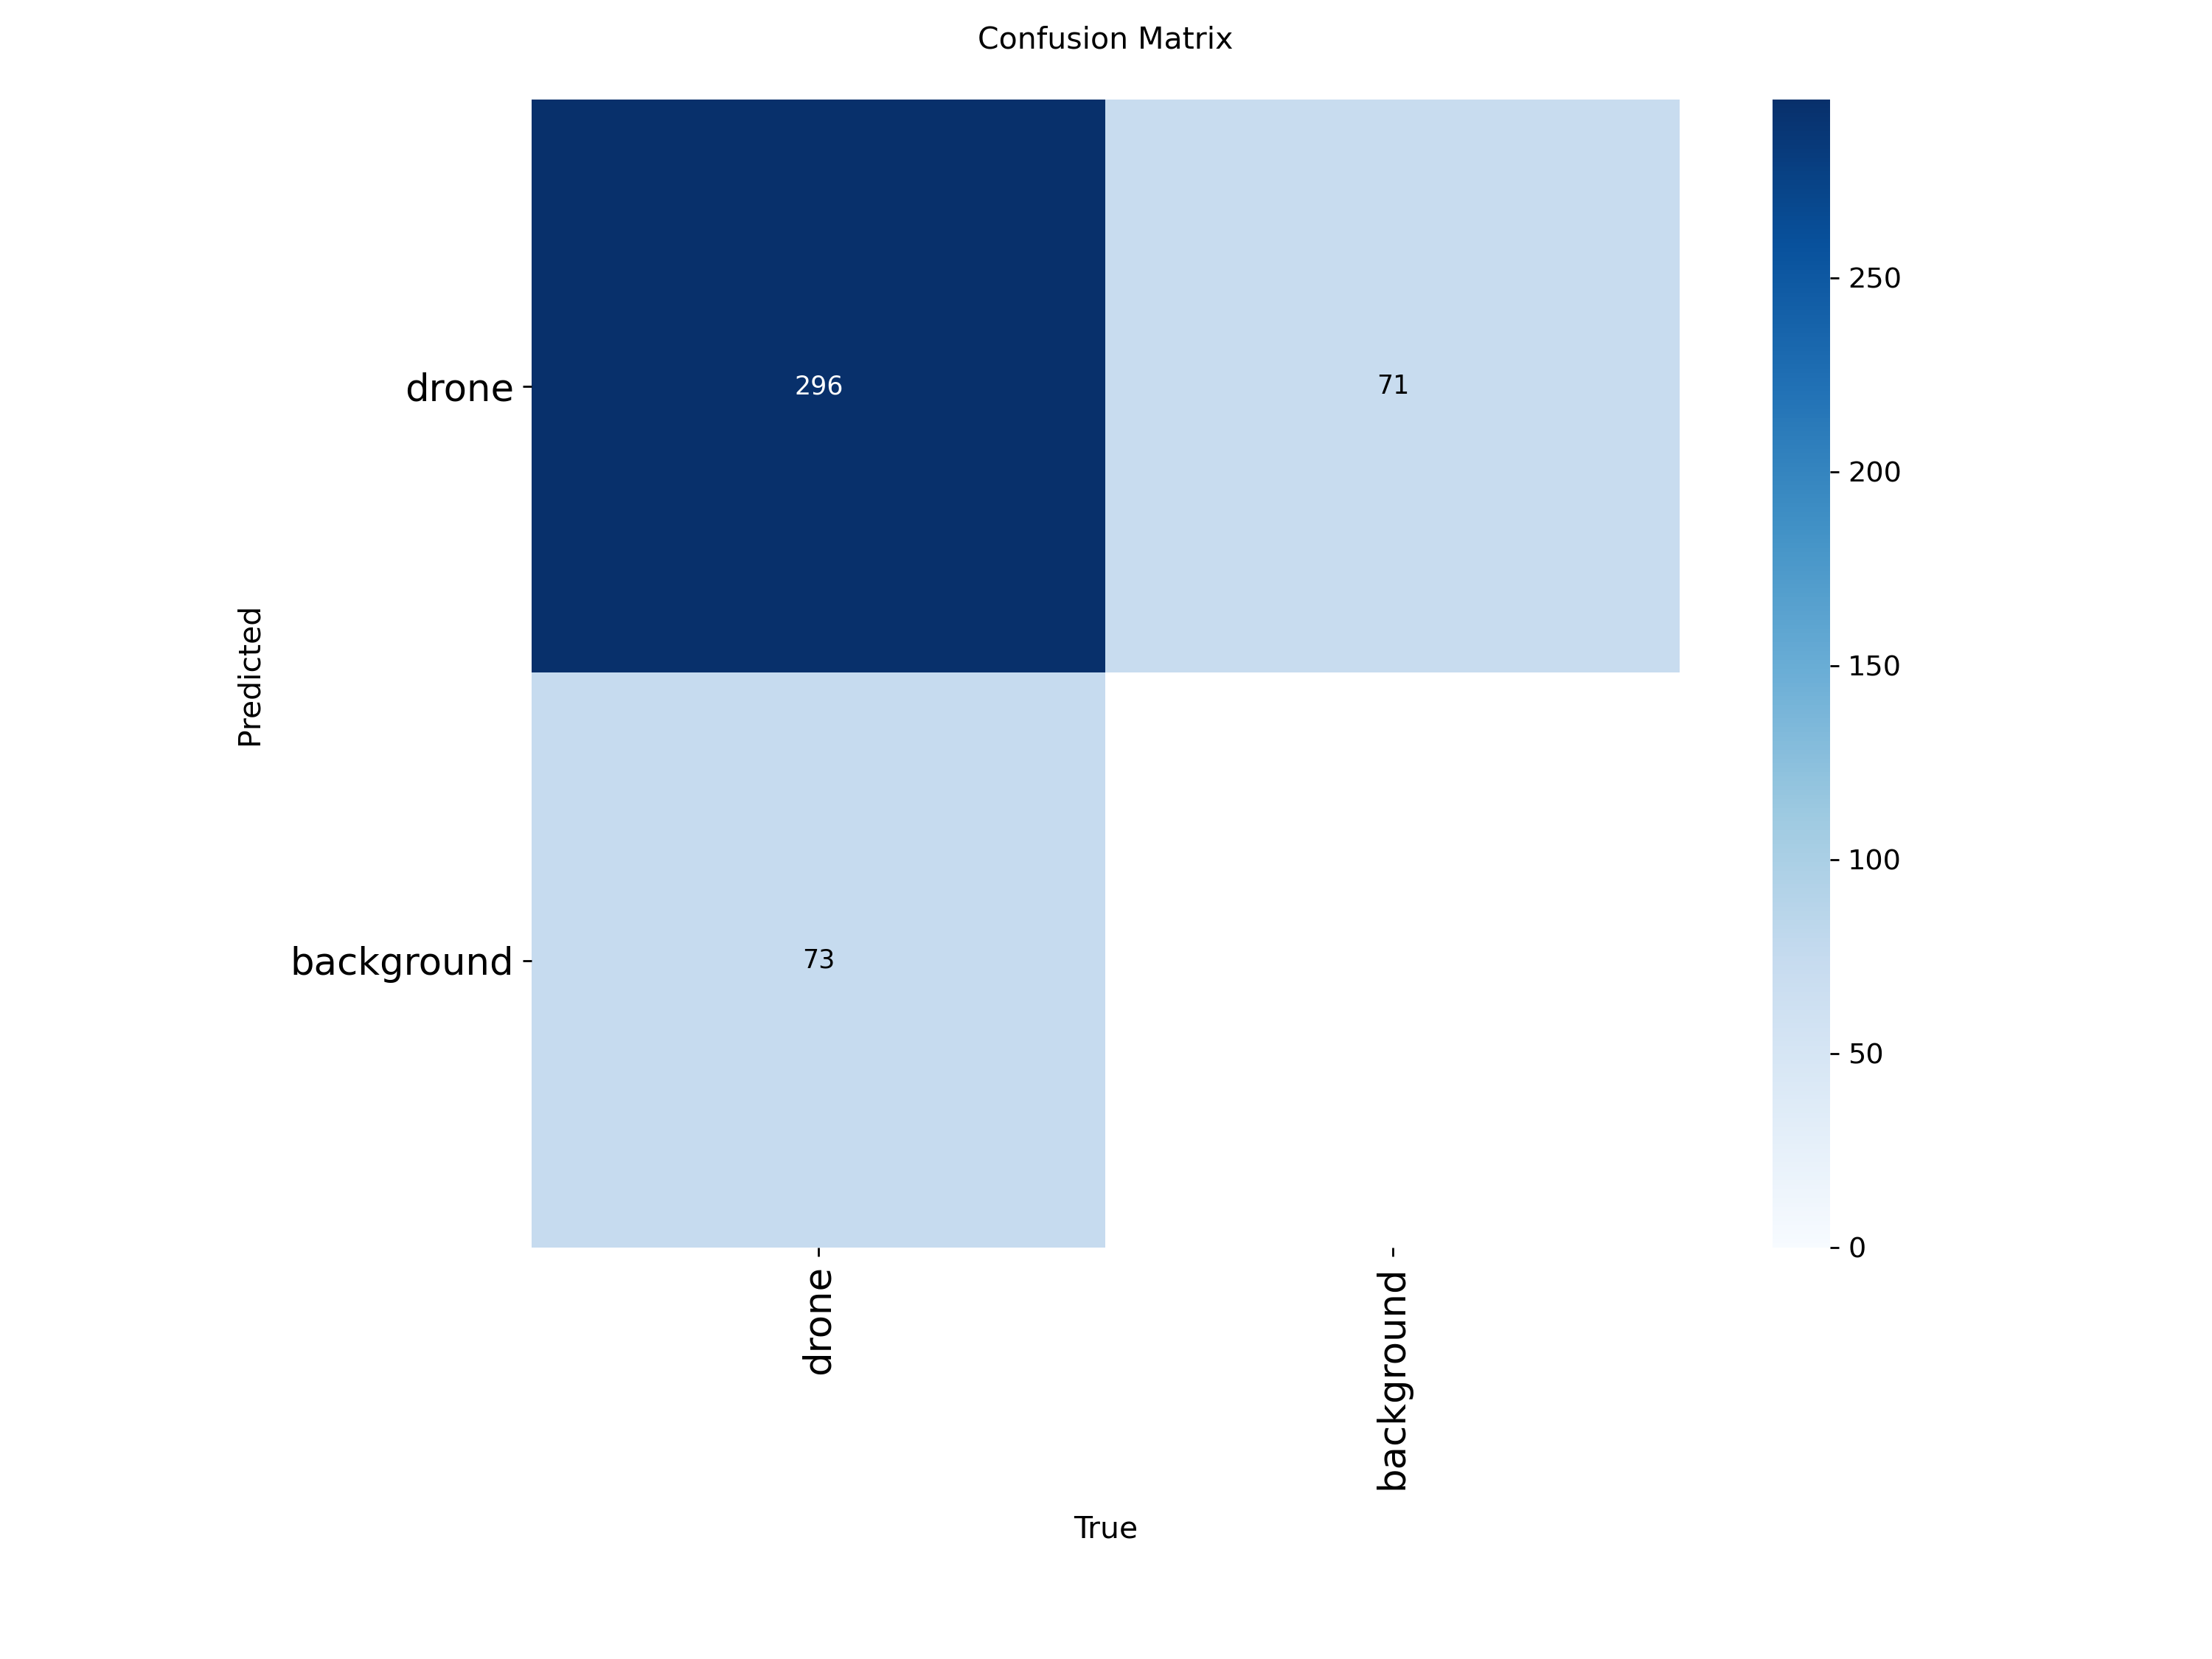


📈 Training Curves:


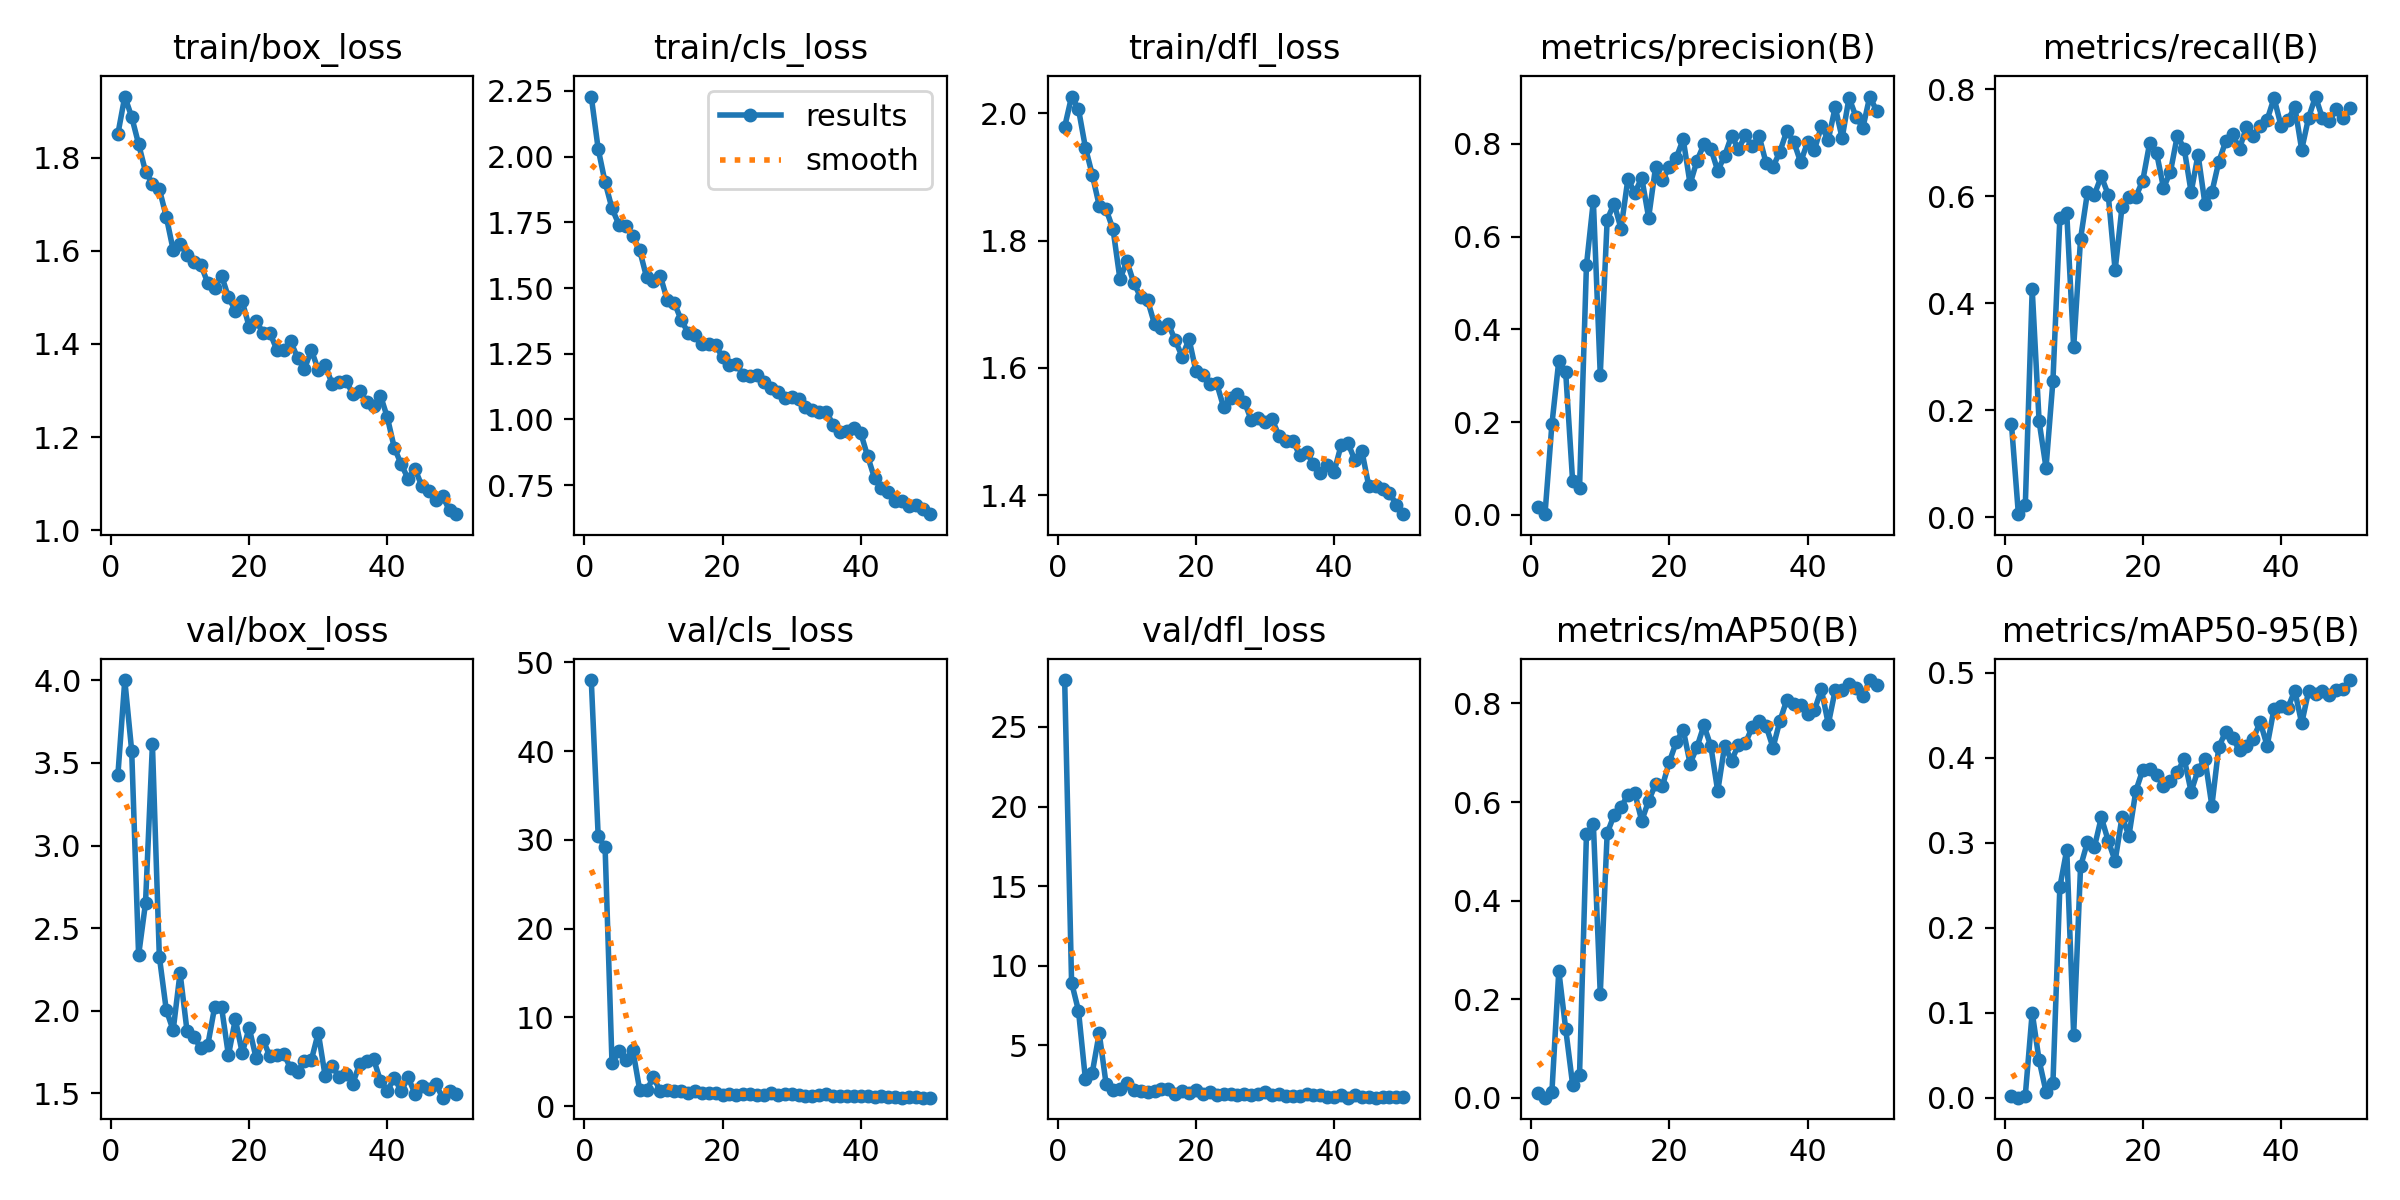


🎯 Validation Predictions:


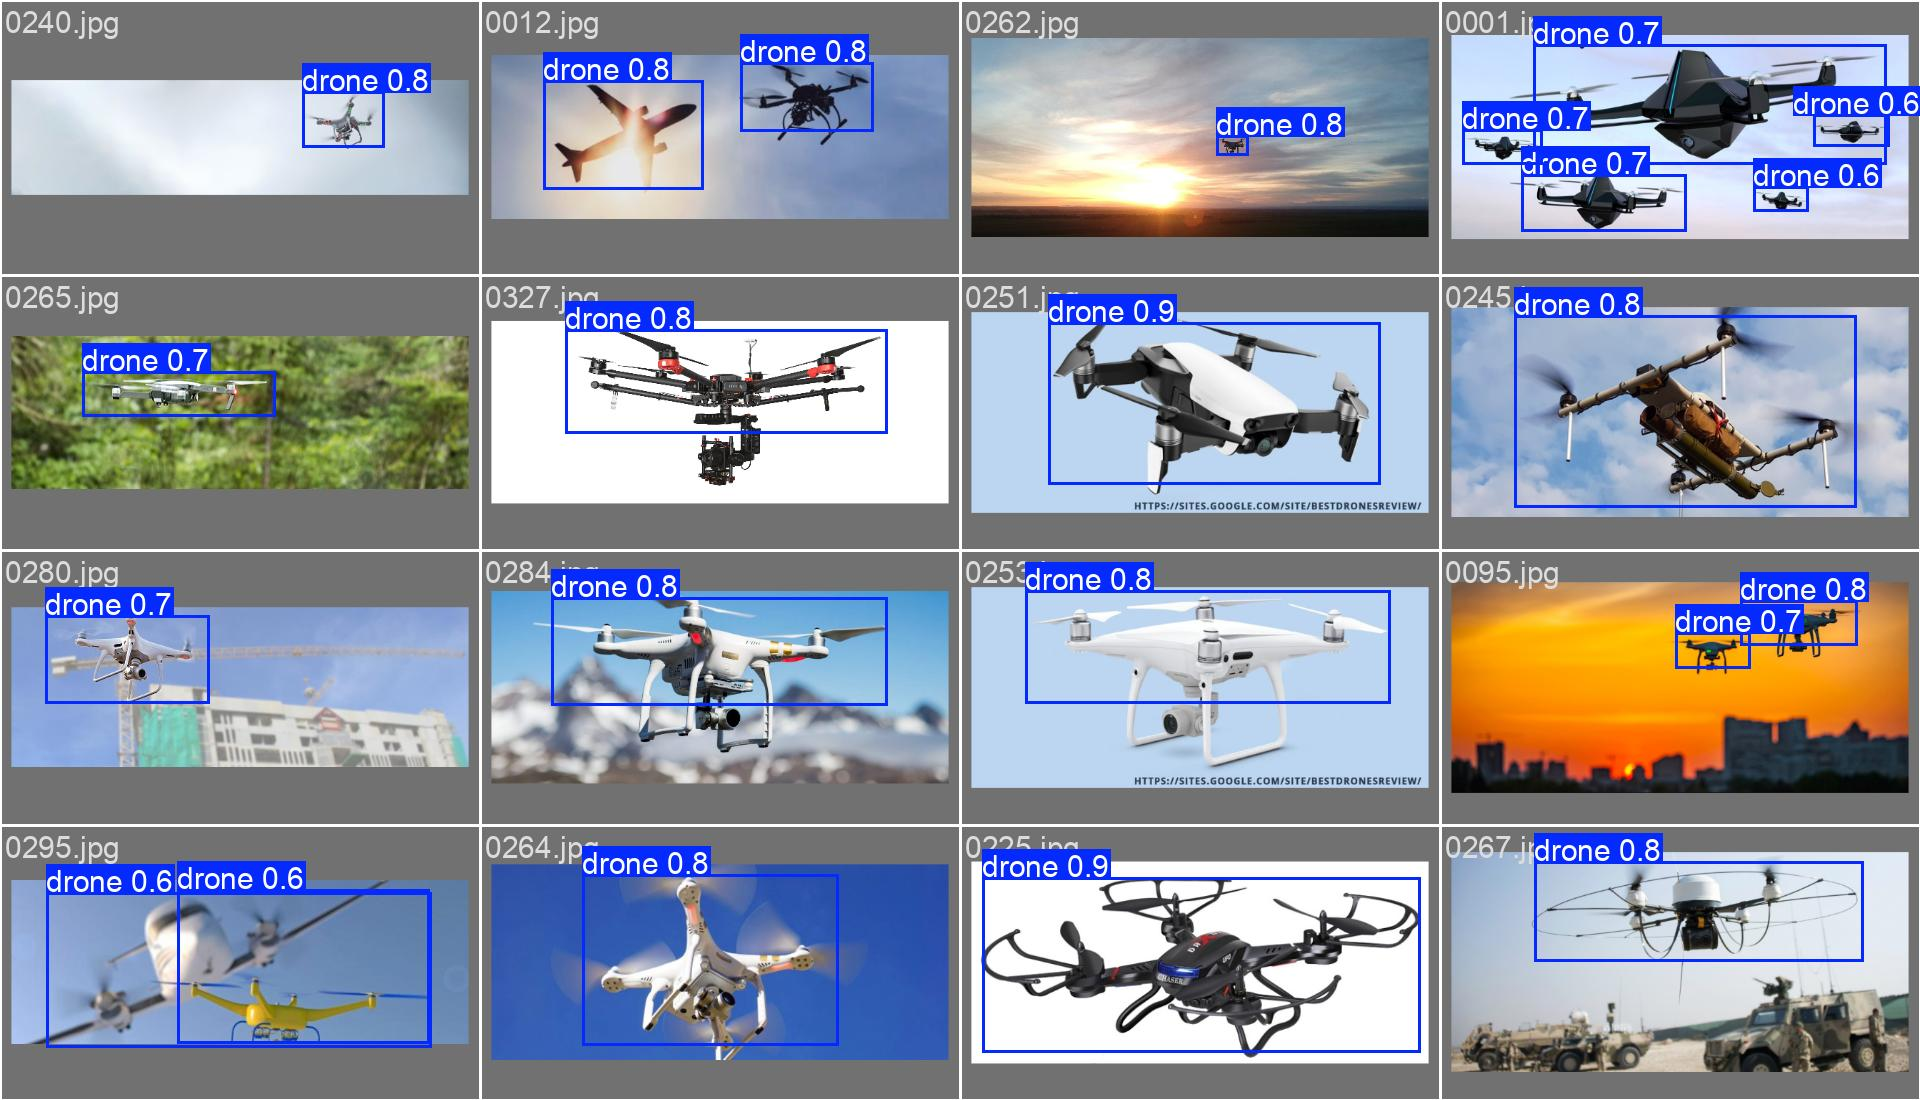

In [30]:
# ===================================================================
# STEP 10: VIEW TRAINING RESULTS
# ===================================================================

print("\n=== TRAINING VISUALIZATIONS ===")

results_dir = 'runs/detect/drone_detection'

# Confusion Matrix
if os.path.exists(f'{results_dir}/confusion_matrix.png'):
    print("\n📊 Confusion Matrix:")
    display(Image(filename=f'{results_dir}/confusion_matrix.png'))

# Training Curves
if os.path.exists(f'{results_dir}/results.png'):
    print("\n📈 Training Curves:")
    display(Image(filename=f'{results_dir}/results.png'))

# Validation Predictions
if os.path.exists(f'{results_dir}/val_batch0_pred.jpg'):
    print("\n🎯 Validation Predictions:")
    display(Image(filename=f'{results_dir}/val_batch0_pred.jpg'))

In [31]:
# ===================================================================
# STEP 11: EXPORT MODEL
# ===================================================================

print("\n=== EXPORTING MODEL ===")

# Export to ONNX format
try:
    onnx_path = model.export(format='onnx')
    print(f"✓ ONNX model exported: {onnx_path}")
except Exception as e:
    print(f"⚠️ ONNX export failed: {e}")


=== EXPORTING MODEL ===
Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from 'runs/detect/drone_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.71...
ONNX: export success ✅ 1.2s, saved as 'runs/detect/drone_detection/weights/best.onnx' (10.1 MB)

Export complete (1.5s)
Results saved to /content/runs/detect/drone_detection/weights
Predict:         yolo predict task=detect model=runs/detect/drone_detection/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/drone_detection/weights/best.onnx imgsz=640 data=/content/drone_dataset/data.yaml  
Visualize:       https://netron.app
✓ ONNX model exported: runs/detect/drone_detection/weights/best.onnx


In [32]:
# ===================================================================
# STEP 12: DOWNLOAD MODEL
# ===================================================================

print("\n=== PREPARING MODEL DOWNLOAD ===")

# Create zip with all important files
!zip -r drone_model.zip \
    runs/detect/drone_detection/weights/best.pt \
    runs/detect/drone_detection/weights/last.pt \
    runs/detect/drone_detection/*.png \
    runs/detect/drone_detection/*.csv

print("\n📦 Downloading model package...")
files.download('drone_model.zip')
print("✓ Model downloaded!")


=== PREPARING MODEL DOWNLOAD ===
  adding: runs/detect/drone_detection/weights/best.pt (deflated 10%)
  adding: runs/detect/drone_detection/weights/last.pt (deflated 10%)
  adding: runs/detect/drone_detection/BoxF1_curve.png (deflated 16%)
  adding: runs/detect/drone_detection/BoxP_curve.png (deflated 17%)
  adding: runs/detect/drone_detection/BoxPR_curve.png (deflated 20%)
  adding: runs/detect/drone_detection/BoxR_curve.png (deflated 16%)
  adding: runs/detect/drone_detection/confusion_matrix_normalized.png (deflated 36%)
  adding: runs/detect/drone_detection/confusion_matrix.png (deflated 37%)
  adding: runs/detect/drone_detection/results.png (deflated 7%)
  adding: runs/detect/drone_detection/results.csv (deflated 58%)

📦 Downloading model package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Model downloaded!


In [33]:
# ===================================================================
# STEP 13: INFERENCE FUNCTION + UPLOAD & TEST
# ===================================================================

print("\n=== INFERENCE FUNCTION ===")

def detect_drones(image_path, conf_threshold=0.25, save_result=True):
    """
    Detect drones in an image

    Args:
        image_path: Path to input image
        conf_threshold: Confidence threshold (0.0 to 1.0)
        save_result: Whether to save annotated image

    Returns:
        results: Detection results
    """
    model = YOLO(best_model_path)
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        iou=0.45,
        save=save_result,
        show=False,
        project='runs/detect',
        name='inference',
        exist_ok=True
    )

    # Display detection info
    for r in results:
        boxes = r.boxes
        num_detections = len(boxes)
        print(f"\n🎯 Detected {num_detections} drone(s) in {os.path.basename(image_path)}")

        if num_detections > 0:
            for i, box in enumerate(boxes):
                conf = box.conf[0].item()
                coords = box.xyxy[0].tolist()
                print(f"   Drone {i+1}: Confidence={conf:.2f}, Box={[int(c) for c in coords]}")
        else:
            print("   No drones detected in this image")

    return results

print("✓ Inference function defined!")


=== INFERENCE FUNCTION ===
✓ Inference function defined!



📸 UPLOAD YOUR OWN IMAGE FOR TESTING

Instructions:
1. Click 'Choose Files' button below
2. Select an image from your computer (JPG, PNG)
3. Wait for upload to complete
4. Detection will run automatically




Saving pexels-jeshoots-com-147458-442587.jpg to pexels-jeshoots-com-147458-442587.jpg

✓ Image uploaded: pexels-jeshoots-com-147458-442587.jpg

🔍 Running drone detection...
------------------------------------------------------------

image 1/1 /content/pexels-jeshoots-com-147458-442587.jpg: 448x640 1 drone, 49.9ms
Speed: 3.1ms preprocess, 49.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/runs/detect/inference

🎯 Detected 1 drone(s) in pexels-jeshoots-com-147458-442587.jpg
   Drone 1: Confidence=0.73, Box=[274, 1486, 3086, 2325]
------------------------------------------------------------

📊 DISPLAYING RESULTS


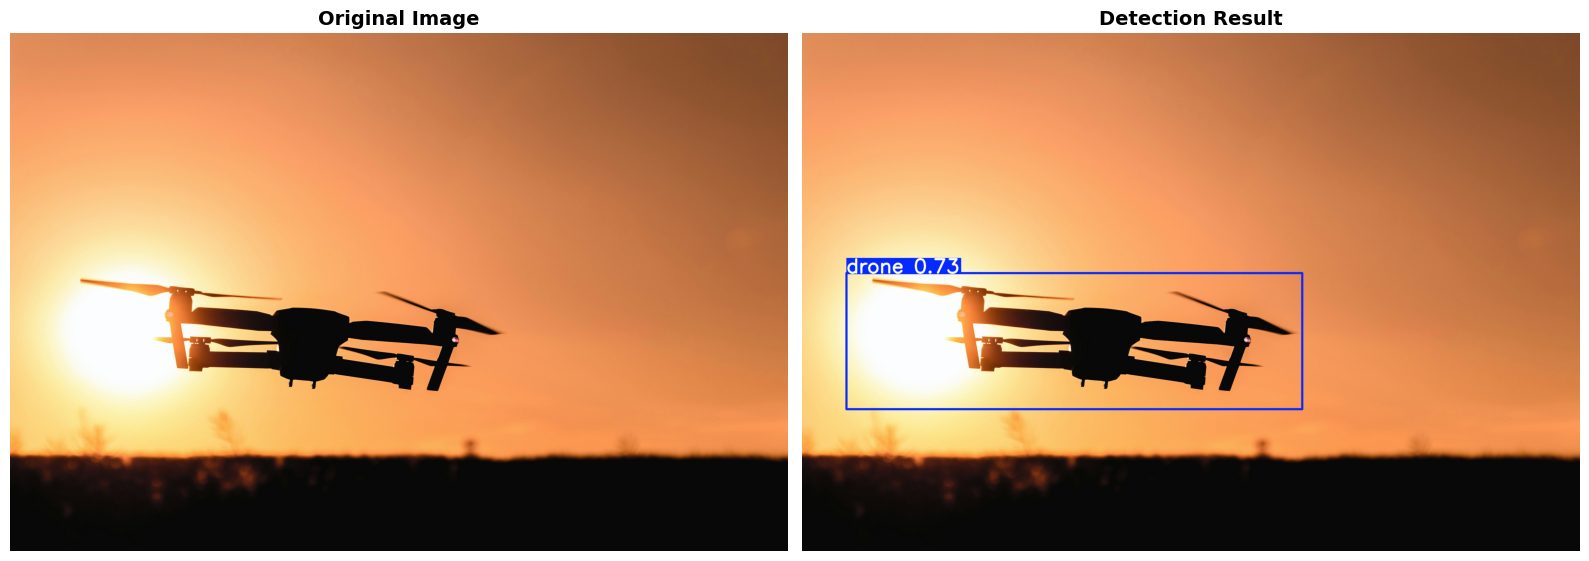


✓ Detection complete!

📈 Detection Statistics:
   Total detections: 1
   Avg confidence: 0.73
   Max confidence: 0.73
   Min confidence: 0.73


In [34]:
# ===================================================================
# TEST THE FUNCTION - UPLOAD YOUR OWN IMAGE
# ===================================================================

print("\n" + "="*60)
print("📸 UPLOAD YOUR OWN IMAGE FOR TESTING")
print("="*60)
print("\nInstructions:")
print("1. Click 'Choose Files' button below")
print("2. Select an image from your computer (JPG, PNG)")
print("3. Wait for upload to complete")
print("4. Detection will run automatically")
print("\n" + "="*60 + "\n")

from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Upload image
uploaded = files.upload()

if uploaded:
    # Get the uploaded filename
    image_name = list(uploaded.keys())[0]
    print(f"\n✓ Image uploaded: {image_name}")

    # Run detection
    print("\n🔍 Running drone detection...")
    print("-" * 60)
    results = detect_drones(image_name, conf_threshold=0.25, save_result=True)
    print("-" * 60)

    # Display results side by side
    print("\n📊 DISPLAYING RESULTS")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Original image
    original_img = PILImage.open(image_name)
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')

    # Detection result
    result_path = f'runs/detect/inference/{image_name}'
    if os.path.exists(result_path):
        result_img = PILImage.open(result_path)
        axes[1].imshow(result_img)
        axes[1].axis('off')
        axes[1].set_title('Detection Result', fontsize=14, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'Result not found',
                    ha='center', va='center', fontsize=12)
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n✓ Detection complete!")

    # Show detection statistics
    for r in results:
        boxes = r.boxes
        if len(boxes) > 0:
            confidences = [box.conf[0].item() for box in boxes]
            print(f"\n📈 Detection Statistics:")
            print(f"   Total detections: {len(boxes)}")
            print(f"   Avg confidence: {sum(confidences)/len(confidences):.2f}")
            print(f"   Max confidence: {max(confidences):.2f}")
            print(f"   Min confidence: {min(confidences):.2f}")
else:
    print("⚠️ No image uploaded. Please run this cell again and select an image.")

In [35]:
# ===================================================================
# FINAL SUMMARY
# ===================================================================

print("\n" + "="*60)
print("🎉 DRONE DETECTION PROJECT COMPLETE!")
print("="*60)

print("\n📊 Project Summary:")
print(f"✓ Dataset: {train_img_count + valid_img_count + test_img_count} total images")
print(f"✓ Training: {train_img_count} images")
print(f"✓ Validation: {valid_img_count} images")
print(f"✓ Testing: {test_img_count} images")
print(f"✓ Model: YOLOv11 Nano")
print(f"✓ Best mAP@50: {metrics.box.map50:.4f}")

print("\n🚀 How to Use:")
print("1. Test on new images:")
print("   uploaded = files.upload()")
print("   detect_drones(list(uploaded.keys())[0])")
print("\n2. Load trained model:")
print(f"   model = YOLO('{best_model_path}')")
print("\n3. Model location:")
print(f"   {best_model_path}")

print("\n💡 Next Steps:")
print("• Fine-tune hyperparameters for better results")
print("• Try larger models (yolo11s.pt, yolo11m.pt)")
print("• Add more training data")
print("• Deploy model to production")

print("\n" + "="*60)
print("Happy Drone Detecting! 🚁")
print("="*60)


🎉 DRONE DETECTION PROJECT COMPLETE!

📊 Project Summary:
✓ Dataset: 1359 total images
✓ Training: 1012 images
✓ Validation: 347 images
✓ Testing: 0 images
✓ Model: YOLOv11 Nano
✓ Best mAP@50: 0.8377

🚀 How to Use:
1. Test on new images:
   uploaded = files.upload()
   detect_drones(list(uploaded.keys())[0])

2. Load trained model:
   model = YOLO('runs/detect/drone_detection/weights/best.pt')

3. Model location:
   runs/detect/drone_detection/weights/best.pt

💡 Next Steps:
• Fine-tune hyperparameters for better results
• Try larger models (yolo11s.pt, yolo11m.pt)
• Add more training data
• Deploy model to production

Happy Drone Detecting! 🚁
